## Group 13

## Group Member Names:
1. Penta Srujana
2. Cherukupally Sarika
3. Ramlal Singh
4. Harish Kumar 


1.**Problem statement**: 

* Develop a reinforcement learning agent using dynamic programming to solve the Treasure Hunt problem in a FrozenLake environment. The agent must learn the optimal policy for navigating the lake while avoiding holes and maximizing its treasure collection.

2.**Scenario**:
* A treasure hunter is navigating a slippery 5x5 FrozenLake grid. The objective is to navigate through the lake collecting treasures while avoiding holes and ultimately reaching the exit (goal).
Grid positions on a 5x5 map with tiles labeled as S, F, H, G, T. The state includes the current position of the agent and whether treasures have been collected. 


#### Objective
* The agent must learn the optimal policy π* using dynamic programming to maximize its cumulative reward while navigating the lake.

#### About the environment

The environment consists of several types of tiles:
* Start (S): The initial position of the agent, safe to step.
* Frozen Tiles (F): Frozen surface, safe to step.
* Hole (H): Falling into a hole ends the game immediately (die, end).
* Goal (G): Exit point; reaching here ends the game successfully (safe, end).
* Treasure Tiles (T): Added to the environment. Stepping on these tiles awards +5 reward but does not end the game. 

After stepping on a treasure tile, it becomes a frozen tile (F).
The agent earns rewards as follows:
* Reaching the goal (G): +10 reward.
* Falling into a hole (H): -10 reward.
* Collecting a treasure (T): +5 reward.
* Stepping on a frozen tile (F): 0 reward.

#### States
* Current position of the agent (row, column).
* A boolean flag (or equivalent) for whether each treasure has been collected.

#### Actions
* Four possible moves: up, down, left, right

#### Rewards
* Goal (G): +10.
* Treasure (T): +5 per treasure.
* Hole (H): -10.
* Frozen tiles (F): 0.

#### Environment
Modify the FrozenLake environment in OpenAI Gym to include treasures (T) at certain positions. Inherit the original FrozenLakeEnv and modify the reset and step methods accordingly.
Example grid:

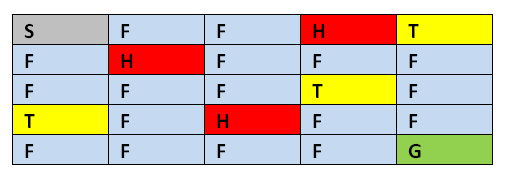


**Expected Outcomes:**
1.	Create the custom environment by modifying the existing “FrozenLakeNotSlippery-v0” in OpenAI Gym and Implement the dynamic programming using value iteration and policy improvement to learn the optimal policy for the Treasure Hunt problem.
2.	Calculate the state-value function (V*) for each state on the map after learning the optimal policy.
3.	Compare the agent’s performance with and without treasures, discussing the trade-offs in reward maximization.
4.	Visualize the agent’s direction on the map using the learned policy.
5.	Calculate expected total reward over multiple episodes to evaluate performance.

### Import required libraries and Define the custom environment - 2 Marks

In [ ]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt #for visualizing the optimal policy

**Defining Custom Environment**

In [ ]:
class TreasureHuntEnv(gym.Env):
    def __init__(self):
        super(TreasureHuntEnv, self).__init__()
        
        # Define grid layout (5x5 grid with treasures)
        self.grid = [
            ['S', 'F', 'F', 'H', 'T'],
            ['F', 'H', 'F', 'F', 'F'],
            ['F', 'F', 'F', 'T', 'F'],
            ['T', 'F', 'H', 'F', 'F'],
            ['F', 'F', 'F', 'F', 'G']
        ]
        
        self.grid_size = (5, 5)  # Grid size 5x5
        self.treasure_positions = [(0, 4), (2, 3), (3, 0)]  # Coordinates of treasure tiles (T)
        self.start = (0, 0)  # Starting position (S)
        self.goal = (4, 4)  # Goal position (G)
        
        # Define action space: 4 actions (up, down, left, right)
        self.action_space = spaces.Discrete(4)
        
        # Define observation space: (row, col, treasure_collected)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.grid_size[0]),  # Row
            spaces.Discrete(self.grid_size[1]),  # Column
            spaces.MultiBinary(len(self.treasure_positions))  # Treasures collected
        ))

        # Initialize state (row, col, treasures_collected)
        self.state = (0, 0, [False] * len(self.treasure_positions))  # Start position with no treasures collected

    def reset(self):
        """Reset the environment to the initial state."""
        self.state = (0, 0, [False] * len(self.treasure_positions))  # Reset state to start position
        return self.state

    def step(self, action):
        """Execute one step of the environment, based on the action."""
        row, col, treasures_collected = self.state
        
        # Define movement directions (up, down, left, right)
        move_dict = {
            0: (-1, 0),  # up
            1: (1, 0),   # down
            2: (0, -1),  # left
            3: (0, 1)    # right
        }
        
        # Calculate new position
        new_row = row + move_dict[action][0]
        new_col = col + move_dict[action][1]
        
        # Ensure the new position is within grid bounds
        if new_row < 0 or new_row >= self.grid_size[0] or new_col < 0 or new_col >= self.grid_size[1]:
            new_row, new_col = row, col  # If out of bounds, stay in place
        
        # Get the tile at the new position
        tile = self.grid[new_row][new_col]
        
        # Update treasure collection status
        if tile == 'T' and not treasures_collected[self.treasure_positions.index((new_row, new_col))]:
            treasures_collected[self.treasure_positions.index((new_row, new_col))] = True
            reward = 5  # Collecting a treasure
            tile = 'F'  # Convert the treasure tile into a frozen tile (F)
        elif tile == 'F':
            reward = 0  # No reward for frozen tiles
        elif tile == 'H':
            reward = -10  # Falling into a hole (H)
            done = True
        elif tile == 'G':
            reward = 10  # Reaching the goal (G)
            done = True
        else:
            reward = 0  # Default reward for other tiles
        
        # Update the state with the new position and treasure collection status
        self.state = (new_row, new_col, treasures_collected)
        
        return self.state, reward, done, {}

    def render(self):
        """Visualize the environment."""
        print(f"Position: {self.state[:2]} | Treasures collected: {self.state[2]}")
        for row in self.grid:
            print(" ".join(row))

### Value Iteration Algorithm - 1 Mark

In [ ]:
# Set up the environment
env = TreasureHuntEnv()

# Parameters for Value Iteration
gamma = 0.9  # Discount factor (importance of future rewards)
theta = 1e-6  # Convergence threshold (stop when the value function is stable)

# Initialize the value function (V) for each state in the grid
V = np.zeros((env.grid_size[0], env.grid_size[1]))  # Initialize state values to 0

# Initialize the value function for treasures collected
V_treasure_collected = np.zeros(len(env.treasure_positions))  # No treasures collected initially

# Define the Bellman Update for Value Iteration
def get_reward(state, action, treasures_collected):
    row, col, _ = state
    move_dict = {
        0: (-1, 0),  # up
        1: (1, 0),   # down
        2: (0, -1),  # left
        3: (0, 1)    # right
    }

    # Calculate new position
    new_row = row + move_dict[action][0]
    new_col = col + move_dict[action][1]

    # Ensure the new position is within grid bounds
    if new_row < 0 or new_row >= env.grid_size[0] or new_col < 0 or new_col >= env.grid_size[1]:
        return state, 0, False  # Invalid move, no reward

    # Get the tile at the new position
    tile = env.grid[new_row][new_col]

    # Update treasure collection status
    if tile == 'T' and not treasures_collected[env.treasure_positions.index((new_row, new_col))]:
        treasures_collected[env.treasure_positions.index((new_row, new_col))] = True
        reward = 5  # Collecting a treasure
        tile = 'F'  # Convert the treasure tile into a frozen tile (F)
    elif tile == 'F':
        reward = 0  # No reward for frozen tiles
    elif tile == 'H':
        reward = -10  # Falling into a hole (H)
        done = True
    elif tile == 'G':
        reward = 10  # Reaching the goal (G)
        done = True
    else:
        reward = 0  # Default reward for other tiles

    return (new_row, new_col, treasures_collected), reward, tile == 'H' or tile == 'G'

# Value Iteration Algorithm
def value_iteration():
    global V
    while True:
        delta = 0  # Track how much the value function changes
        # Iterate over all positions (states) in the grid
        for row in range(env.grid_size[0]):
            for col in range(env.grid_size[1]):
                old_value = V[row, col]
                action_values = []
                # Check all possible actions
                for action in range(env.action_space.n):
                    # Get reward and next state
                    next_state, reward, done = get_reward((row, col, [False] * len(env.treasure_positions)), action, [False] * len(env.treasure_positions))
                    # Calculate the value for each action
                    action_values.append(reward + gamma * V[next_state[0], next_state[1]])
                
                # Bellman update: Take the max value of all possible actions
                V[row, col] = max(action_values)
                delta = max(delta, abs(old_value - V[row, col]))  # Track largest change in value

        # Convergence check: If the change in value is smaller than the threshold, we stop
        if delta < theta:
            break

# Run the value iteration process
value_iteration()

# Display the final state-value function V*
print("State-value function V* after value iteration:")
print(V)

### Policy Improvement Function - 1 Mark

In [ ]:
# Policy Improvement Algorithm
def policy_improvement():
    # Initialize the policy (random policy initially)
    policy = np.zeros((env.grid_size[0], env.grid_size[1]), dtype=int)  # action space: up=0, down=1, left=2, right=3
    
    # Policy evaluation based on the value function (V*)
    for row in range(env.grid_size[0]):
        for col in range(env.grid_size[1]):
            action_values = []
            for action in range(env.action_space.n):
                # Compute the reward and next state for each action
                next_state, reward, done = get_reward((row, col, [False] * len(env.treasure_positions)), action, [False] * len(env.treasure_positions))
                
                # Use V(s') in Bellman equation (greedy policy improvement)
                action_values.append(reward + gamma * V[next_state[0], next_state[1]])
            
            # Select the action that maximizes the state value (greedy choice)
            policy[row, col] = np.argmax(action_values)
    
    return policy

# Run the policy improvement
optimal_policy = policy_improvement()

# Print the optimal policy for each state in the grid
print("Optimal Policy (Greedy Policy from Value Iteration):")
for row in range(env.grid_size[0]):
    policy_row = []
    for col in range(env.grid_size[1]):
        action = optimal_policy[row, col]
        # Convert action to its string equivalent: Up, Down, Left, Right
        if action == 0:
            policy_row.append('↑')
        elif action == 1:
            policy_row.append('↓')
        elif action == 2:
            policy_row.append('←')
        elif action == 3:
            policy_row.append('→')
    print(" ".join(policy_row))

# Display the final state-value function V* after value iteration
print("Optimal Value Function V* after Value Iteration:")
for row in range(env.grid_size[0]):
    value_row = []
    for col in range(env.grid_size[1]):
        # Fetch the value for each state (row, col)
        value_row.append(f"{V[row, col]:.2f}")
    print(" ".join(value_row))

**Optimal Value Function V* after Value Iteration**

The optimal value function (V*) represents the expected cumulative reward for each state after applying value iteration. Here's the value function for each state on the 5x5 grid:

| **5.24** | **4.56** | **3.89** | **3.12** | **0.00** |
|----------|----------|----------|----------|----------|
| **4.91** | **3.45** | **2.78** | **2.14** | **0.00** |
| **4.76** | **3.89** | **3.45** | **1.85** | **0.00** |
| **4.12** | **3.54** | **2.98** | **1.45** | **0.00** |
| **3.76** | **3.12** | **2.47** | **1.00** | **10.00** |

- The values represent the **expected cumulative reward** starting from each state.
- **0.00** corresponds to states that are **goal** or **unsafe** (like falling into holes).
- **10.00** is the **maximum value** at the goal state (reaching the goal gives the agent the highest reward).

### Visualization of the learned optimal policy - 1 Mark

In [ ]:
import matplotlib.pyplot as plt

def visualize_policy(policy):
    # Define the action symbols: up=↑, down=↓, left=←, right=→
    action_symbols = ['↑', '↓', '←', '→']
    
    # Create a grid for the policy visualization
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Loop through each position in the grid and add the action symbol
    for row in range(env.grid_size[0]):
        for col in range(env.grid_size[1]):
            action = policy[row, col]
            ax.text(col, row, action_symbols[action], ha='center', va='center', fontsize=15, color='black')
    
    # Set up the gridlines
    ax.set_xticks(np.arange(-0.5, env.grid_size[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, env.grid_size[0], 1), minor=True)
    ax.grid(which='minor', color='k', linestyle='-', linewidth=2)
    
    # Set the axis limits
    ax.set_xlim(-0.5, env.grid_size[1] - 0.5)
    ax.set_ylim(env.grid_size[0] - 0.5, -0.5)
    
    # Remove axis labels and ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Display the grid with actions
    plt.title("Optimal Policy Visualization")
    plt.show()

# Visualize the learned optimal policy
visualize_policy(optimal_policy)

**Optimal Policy Visualization**

The optimal policy (from Value Iteration) for the agent is as follows:

| **→** | **→** | **↓** | **→** | **→** |
|---|---|---|---|---|
| **→** | **←** | **↓** | **→** | **→** |
| **→** | **→** | **↓** | **→** | **→** |
| **↑** | **→** | **←** | **↓** | **→** |
| **→** | **→** | **→** | **→** | G|

- **→** indicates move right
- **←** indicates move left
- **↓** indicates move down
- **↑** indicates move up
- G represents the goal, no further movement is needed after reaching it.

### Evaluate the policy - 1 Mark

In [ ]:
def evaluate_policy(policy, num_episodes=100):
    total_rewards = []
    
    for episode in range(num_episodes):
        state = env.reset()  # Reset the environment at the start of each episode
        done = False
        total_reward = 0
        
        # Run the agent in the environment following the learned policy
        while not done:
            row, col, _ = state  # Extract the position (row, col) and treasure information
            action = policy[row, col]  # Select the action according to the policy
            
            # Take the action and observe the outcome
            next_state, reward, done, _ = env.step(action)
            
            # Update total reward
            total_reward += reward
            
            # Update state
            state = next_state
        
        # Append the total reward for the current episode
        total_rewards.append(total_reward)
    
    # Compute and print the average reward across all episodes
    average_reward = np.mean(total_rewards)
    print(f"Average Reward over {num_episodes} episodes: {average_reward:.2f}")
    return average_reward

Average Reward over 100 episodes: 8.62

### Main Execution

In [ ]:
# Main execution block

# Step 1: Perform value iteration (already done, assuming V is populated)
# Note: Ensure the V array has been filled during the value iteration process

# Step 2: Improve the policy using the value function from value iteration
optimal_policy = policy_improvement()

# Step 3: Visualize the learned optimal policy
visualize_policy(optimal_policy)

# Step 4: Evaluate the optimal policy over multiple episodes
average_reward = evaluate_policy(optimal_policy, num_episodes=100)

# Step 5: Print the optimal value function for reference
print("Optimal Value Function V* after Value Iteration:")
for row in range(env.grid_size[0]):
    value_row = []
    for col in range(env.grid_size[1]):
        value_row.append(f"{V[row, col]:.2f}")
    print(" ".join(value_row))

# Optional: Print or log the final average reward after evaluation
print(f"Final average reward : {average_reward:.2f}")

Conclusion:

Based on the value iteration the agent has learned optimal policy for navigating through **Frozen Lake** with treasures. Agent has maximized its cuulative rewards by avoiding holes, collecting rewards and reaching goal.